# **Setup**

**Download data**

In [5]:
from huggingface_hub import hf_hub_download
import zipfile
import os

extract_dir = "./cars100"

# # Download the zip file
# zip_path = hf_hub_download(
#     repo_id="lukasskellijs/carssdf",
#     filename="cars100.zip",
#     repo_type="dataset"
# )

# # Create output folder
# os.makedirs(extract_dir, exist_ok=True)

# # Unzip
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)
# print(f"Unzipped to: {extract_dir}")

**Define PyTorch dataset**

In [6]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class SDFDataset(Dataset):
    def __init__(self, path_to_data):
        self.path = path_to_data
        self.files = os.listdir(self.path)

    def __len__(self):
        return len(self.files)	

    def __getitem__(self, idx):
        return torch.load(os.path.join(self.path, self.files[idx]))

    def get_name(self, idx):
        return self.files[idx]

**Work with data**

Viewing: 100715345ee54d7ae38b52b4ee9d36a3.pt


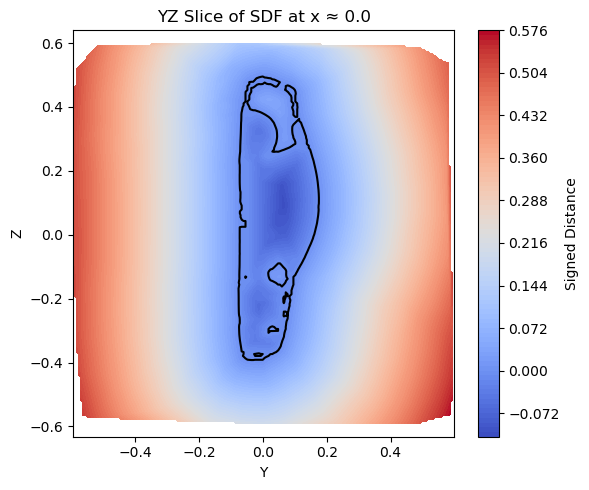

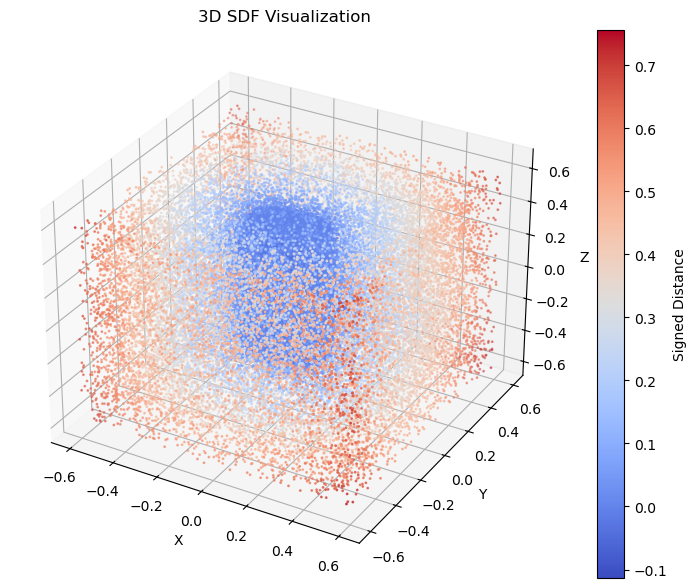

Shape: torch.Size([50000, 4])
Min SDF: -0.11313788592815399
Max SDF: 0.7566637396812439
Mean SDF: 0.1938696801662445
Std SDF: 0.1980745792388916
Min X: -0.5998806953430176
Max X: 0.5999709367752075
Min Y: -0.5999510288238525
Max Y: 0.5999920964241028
Min Z: -0.5999487638473511
Max Z: 0.6279000639915466


In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

dataset = SDFDataset(extract_dir)

# get example 
ID = 0
example = dataset[ID]
print("Viewing:", dataset.get_name(ID))


""" Define some utility functions """
# Note some of these might be very heavy to run - consider running on cluster

def visualize_sdf_3d(sample):
    # Convert to NumPy
    coords = sample[:, :3].numpy()  # (x, y, z)
    sdf = sample[:, 3].numpy()      # scalar values for color

    # Create 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot colored by sdf values
    p = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=sdf, cmap='coolwarm', s=1)

    # Add colorbar
    fig.colorbar(p, ax=ax, label='Signed Distance')

    # Axes settings
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D SDF Visualization')

    plt.tight_layout()
    plt.show()

def visualize_sdf_2d(sample, x_target = 0.0, tolerance = 0.01):
    data = sample.numpy()

    # Mask for points near x = x_target
    slice_mask = np.abs(data[:, 0] - x_target) < tolerance # creates boolean mask of points that are within our range
    yz_slice = data[slice_mask]

    # Unpack y, z, sdf values
    y, z, sdf = yz_slice[:, 1], yz_slice[:, 2], yz_slice[:, 3]

    # Create regular grid in YZ plane
    grid_y, grid_z = np.mgrid[y.min():y.max():200j, z.min():z.max():200j]

    # Interpolate sdf values onto the grid
    grid_sdf = griddata((y, z), sdf, (grid_y, grid_z), method='linear')

    plt.figure(figsize=(6, 5))
    cont = plt.contourf(grid_y, grid_z, grid_sdf, levels=100, cmap='coolwarm')
    plt.contour(grid_y, grid_z, grid_sdf, levels=[0], colors='black', linewidths=1.5)
    plt.colorbar(cont, label='Signed Distance')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title(f'YZ Slice of SDF at x ≈ {x_target}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def print_summary(sample):
    coords = sample[:, :3].numpy()  # (x, y, z)
    sdf = sample[:, 3].numpy()      # scalar values for color

    # print summary of SDF in nicely formatted table
    print(f"Shape: {sample.shape}")
    print(f"Min SDF: {sdf.min()}")
    print(f"Max SDF: {sdf.max()}")
    print(f"Mean SDF: {sdf.mean()}")
    print(f"Std SDF: {sdf.std()}")
    print(f"Min X: {coords[:,0].min()}")
    print(f"Max X: {coords[:,0].max()}")
    print(f"Min Y: {coords[:,1].min()}")
    print(f"Max Y: {coords[:,1].max()}")
    print(f"Min Z: {coords[:,2].min()}")
    print(f"Max Z: {coords[:,2].max()}")

visualize_sdf_2d(example)
visualize_sdf_3d(example)
print_summary(example)
